In [1]:
import torch
from torch import distributions as dist
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from SBM_SDE_classes import *
from obs_and_flow import *
from kalman_filter import *
from LogitNormal import *

# Load data

In [3]:
T = 1000
dt = 1.0
N = int(T / dt)   # number of discretized time steps EXCLUDING the 0th step (including would be N + 1)
N, T, dt

(1000, 1000, 1.0)

In [4]:
save_dir = 'data/toy_ssm1'
theta_file = '{}/theta.pt'.format(save_dir)
p_x0_file = '{}/p_x0.pt'.format(save_dir)
y_dict_file = '{}/y_dict.pt'.format(save_dir)
theta = torch.load(theta_file)
p_x0 = torch.load(p_x0_file)
y_dict = torch.load(y_dict_file)

In [5]:
theta0, theta1 = theta
theta0, theta1

(tensor(0.6000), tensor(0.9000))

In [6]:
q_raw_file = '{}/old_q_raw.pt'.format(save_dir)
q_theta_raw, _ = torch.load(q_raw_file)

In [7]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = dist.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [8]:
q_theta = extract_dist(q_theta_raw)
q_theta

MultivariateLogitNormal(loc: torch.Size([2]), scale_tril: torch.Size([2, 2]), a: torch.Size([2]), b: torch.Size([2]))

In [9]:
q0_marg = RescaledLogitNormal(q_theta.loc[0], torch.diag(q_theta.covariance_matrix)[0].sqrt(), q_theta.a[0], q_theta.b[0])
q1_marg = RescaledLogitNormal(q_theta.loc[1], torch.diag(q_theta.covariance_matrix)[1].sqrt(), q_theta.a[1], q_theta.b[1])

In [10]:
def approx_mode(q_theta, num_pts=1000, eps=1e-6):
    a, b = q_theta.a, q_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    log_pdf = q_theta.log_prob(theta_range)
    return theta_range[torch.argmax(log_pdf)]

In [11]:
theta0_mode = approx_mode(q0_marg)
theta1_mode = approx_mode(q1_marg)
theta0_mode, theta1_mode

(tensor(0.4985), tensor(0.9219))

# Kalman filter

Given fixed hyperparameters $\mu_\theta, \sigma_\theta, a, b, \mu_{x_0}, \sigma_x, \sigma_y$ and observed $y$, consider the following toy model:
- $\theta_0, \theta_1 \sim \text{LogitNormal}(\mu_\theta, \sigma_\theta, a, b)$
- $x_0 \sim N(\mu_{x_0}, \sigma_x)$
- $x_t \sim N(\theta_0+\theta_1x_{t-1}, \sigma_x)$
- $y_{t'} \sim N(x_{t'}, \sigma_y)$, where $t'$ is observed time steps

with $\sigma$ as a *scale* parameter instead of variance.

## Transition
To apply the Kalman filter, we require a linear function of the form:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \mathbf{B}_t \mathbf{u}_t + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise with *covariance* $\mathbf{Q}_t$.

Rewriting the toy transition model this way, we have:
- $\mathbf{A}_t = \begin{bmatrix} \theta_1 \end{bmatrix}$
- $\mathbf{B}_t = \begin{bmatrix} \theta_0 \end{bmatrix}$
- $\mathbf{u}_t= \begin{bmatrix} 1 \end{bmatrix}$
- $\mathbf{Q}_t = \begin{bmatrix} \sigma_x^2 \end{bmatrix}$

Although the toy model is 1-dimensional, since the `KalmanFilter` class expects matrix parameters, we use $1 \times 1$ matrices to represent the parameters instead of scalars.

In [12]:
def get_trans_params(theta0, theta1):
    A = theta1.repeat(N + 1).reshape((-1, 1, 1)) # (N + 1, state_dim, state_dim)
    B = theta0.reshape((1, 1)) # (state_dim, state_dim)
    u = torch.ones((N + 1, 1)) # (N + 1, state_dim)
    Q = p_x0.variance.reshape((1, 1)) # (state_dim, state_dim)
    return (A, B, u, Q)
A_mode, B_mode, _, _ = get_trans_params(theta0_mode, theta1_mode)
A_mode.shape, B_mode.shape, A_mode[0], B_mode

(torch.Size([1001, 1, 1]),
 torch.Size([1, 1]),
 tensor([[0.9219]]),
 tensor([[0.4985]]))

In [13]:
def get_trans_params(theta0, theta1):
    A = theta1.repeat(N + 1).reshape((-1, 1, 1)) # (N + 1, state_dim, state_dim)
    B = theta0.reshape((1, 1)) # (state_dim, state_dim)
    u = torch.ones((N + 1, 1)) # (N + 1, state_dim)
    Q = p_x0.variance.reshape((1, 1)) # (state_dim, state_dim)
    return (A, B, u, Q)
A, B, u, Q = get_trans_params(theta0, theta1)
A.shape, B.shape, u.shape, Q.shape, A[0], B

(torch.Size([1001, 1, 1]),
 torch.Size([1, 1]),
 torch.Size([1001, 1]),
 torch.Size([1, 1]),
 tensor([[0.9000]]),
 tensor([[0.6000]]))

## Observation
Expressing the observation as a linear function of the form: 
$$ \mathbf{y}_t = \mathbf{C}_t \mathbf{x}_{t} + \mathbf{D}_t \mathbf{u}_t + \boldsymbol{\delta}_t$$

where $\boldsymbol{\delta}_t \sim N(\mathbf{0}, \mathbf{R}_t)$ is a Gaussian observation noise with *covariance* $\mathbf{R}_t$, we have:
- $\mathbf{C}_t = \begin{bmatrix} 1 \end{bmatrix}$
- $\mathbf{D}_t = \begin{bmatrix} 0 \end{bmatrix}$
- $\mathbf{R}_t = \begin{bmatrix} \sigma_y^2 \end{bmatrix}$

In [14]:
C = torch.ones((N + 1, 1, 1)) # (N + 1, state_dim, state_dim)
D = torch.zeros((1, 1)) # (state_dim, state_dim)
R = (y_dict['sigma_y']**2).reshape((1, 1)) # (state_dim, state_dim)
C.shape, D.shape, R.shape

(torch.Size([1001, 1, 1]), torch.Size([1, 1]), torch.Size([1, 1]))

In [15]:
# Initial p(x0) = MVN(loc_vector, covariance_matrix)
x0_mu = p_x0.loc.reshape(1) # (state_dim, )
x0_sigma = p_x0.variance.reshape((1, 1)) # (state_dim, state_dim)
x0_mu.shape, x0_sigma.shape

(torch.Size([1]), torch.Size([1, 1]))

In [16]:
obs_every = (y_dict['t_y'][1] - y_dict['t_y'][0]).item()
obs_every

10.0

In [17]:
y = y_dict['y'].T # (len_obs, state_dim)
y.shape

torch.Size([101, 1])

In [18]:
kf = KalmanFilter(A, B, C, D, Q, R, N, init_mu=x0_mu, init_sigma=x0_sigma)
kf.forward(y, y_gap=obs_every/dt, u=u)
kf.backward()

In [19]:
kf_mode = KalmanFilter(A_mode, B_mode, C, D, Q, R, N, init_mu=x0_mu, init_sigma=x0_sigma)
kf_mode.forward(y, y_gap=obs_every/dt, u=u)
kf_mode.backward()

In [ ]:
A_mode, A

In [ ]:
B_mode, B

### Save results

In [26]:
kf_file = '{}/kf.pt'.format(save_dir)
torch.save((kf, kf_mode), kf_file)

### Debug

In [ ]:
kf.sigma_smooth[0]

In [ ]:
A[1] @ kf.mu_filter[0] + B @ u[1]

In [ ]:
kf.mu_filter[0]

# Visualizing the posterior

The *filtered* posterior is the distribution $p(x_t|y_{1:t'}, u_{1:t})$, where $t'$ is the time of the most recent observation. The *smoothed* posterior is the distribution $p(x_t|y_{1:T})$.

In [23]:
def plot_post(kf, T, dt, y, t_y, state_idx, plot_sd=False, show_legend=True, labels=['SOC', 'DOC', 'MBC']):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (15, 4)})
    times = torch.tensor(np.arange(0, T + dt, dt))
    obs = y[:, state_idx]
    mean_filter = kf.mu_filter[:, state_idx]
    mean_smooth = kf.mu_smooth[:, state_idx]
    
    if plot_sd:
        sd_filter = kf.sigma_filter[:, state_idx, state_idx].sqrt()
        #rv_filter = dist.normal.Normal(mean_filter, sd_filter)
        #plt.fill_between(T_span, rv_filter.icdf(torch.tensor(0.05)), rv_filter.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Filtered 5-95th percentile')
        plt.fill_between(times, mean_filter - 2*sd_filter, mean_filter + 2*sd_filter, alpha=0.5,
                         linewidth=0, label='Filtered $\\mu \pm 2\sigma$')
        
        sd_smooth = kf.sigma_smooth[:, state_idx, state_idx].sqrt()
        #rv_smooth = dist.normal.Normal(mean_smooth, sd_smooth)
        #plt.fill_between(T_span, rv_smooth.icdf(torch.tensor(0.05)), rv_smooth.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Smoothed 5-95th percentile')
        plt.fill_between(times, mean_smooth - 2*sd_smooth, mean_smooth + 2*sd_smooth, alpha=0.5,
                         linewidth=0, label='Smoothed $\\mu \pm 2\sigma$')
        
    plt.plot(times, mean_filter, label='Filtered mean')
    plt.plot(times, mean_smooth, label='Smoothed mean')
    plt.plot(t_y, obs, linestyle='None', marker='o', label='Observed')
    
    plt.xlabel('Hour')
    plt.ylabel(labels[state_idx])
    plt.title('True posterior $q(x|\\theta, y)$')
    if show_legend: plt.legend()

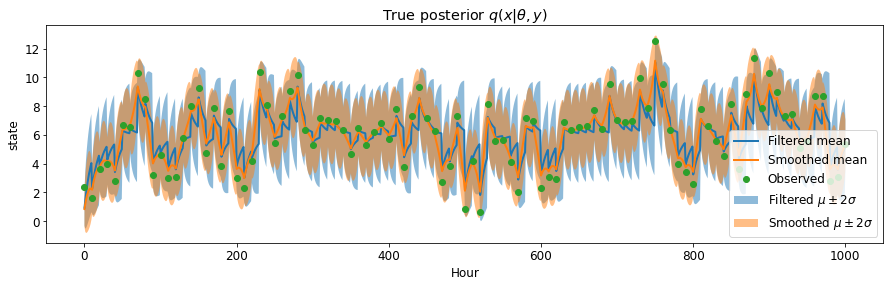

In [24]:
plot_post(kf, T, dt, y, y_dict['t_y'], 0, plot_sd=True, labels=['state'])

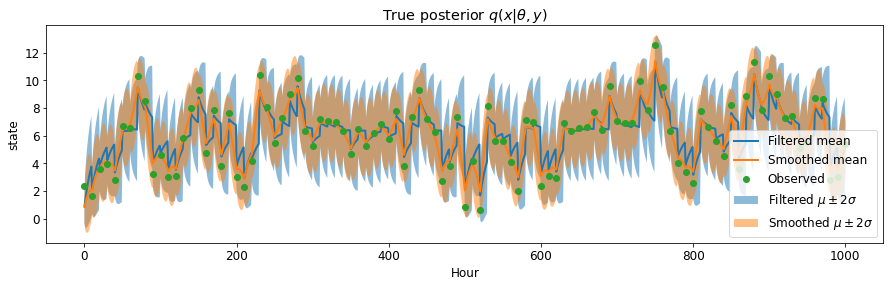

In [25]:
plot_post(kf_mode, T, dt, y, y_dict['t_y'], 0, plot_sd=True, labels=['state'])

In [ ]:
plot_post(obs_vals, 1, plot_sd=True)

In [ ]:
plot_post(obs_vals, 1)

In [ ]:
plot_post(obs_vals, 2, plot_sd=True)

In [ ]:
plot_post(obs_vals, 2)

## Testing the implementation: The constant velocity model

No need to worry about this part, it's for a different model! We used this for debugging purposes because we know the correct posterior for the model.

In [ ]:
import h5py

In [ ]:
sigma_v = 0.01
sigma_x = 0.01/3
sigma_y = 20

In [ ]:
track_file = h5py.File('track.mat', 'r')
track_file.keys()

In [ ]:
track_data = torch.tensor(track_file['data'], dtype=torch.float).squeeze()
track_data.shape

In [ ]:
mu0 = torch.tensor(track_file['x0'], dtype=torch.float).squeeze()
sigma0 = torch.tensor(track_file['P0'], dtype=torch.float)
mu0.shape, sigma0.shape

In [ ]:
T = len(track_data)
A = torch.tensor([[1, 1], [0, 1]], dtype=torch.float).unsqueeze(0) * torch.ones((T + 1, 1, 1))
Q = torch.tensor([[sigma_x, 0], [0, sigma_v]], dtype=torch.float)
C = torch.tensor([1, 0], dtype=torch.float).reshape((1, -1)).unsqueeze(0) * torch.ones((T + 1, 1, 1))
R = torch.tensor(sigma_y, dtype=torch.float)

In [ ]:
B, D = torch.eye(2), torch.ones(2)

In [ ]:
kf = KalmanFilter(A, B, C, D, Q, R, T - 1, init_mu=mu0, init_sigma=sigma0)
kf.forward(track_data)
kf.backward()

In [ ]:
T_span = torch.arange(100)
obs_times = torch.arange(100)
plot_post(track_data.unsqueeze(1), 0, plot_sd=True, labels=['State', 'State 2'])

In [ ]:
z = torch.arange(15).reshape((5, 3))
mu = torch.arange(15).reshape((5, 3))
z.shape, mu.shape

In [ ]:
mu_co2 = torch.einsum('ij,ij->i', z, mu)

In [ ]:
T = z.shape[0]
[z[i] @ mu[i] for i in range(T)]

In [ ]:
mu

In [ ]:
sigma = torch.arange(45).reshape((5, 3, 3))
torch.einsum('ij,ijk,ik->i', z, sigma, z)

In [ ]:
[z[i] @ sigma[i] @ z[i] for i in range(T)]

In [ ]:
z[0].reshape((1, -1)) @ sigma[0] @ z[0].reshape((-1, 1))

In [ ]:
z[0], sigma[0]